In [124]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import scipy.stats as stats
from scipy.stats import norm, t


In [125]:
df = pd.read_csv("/home/hujianjin/projects/LinearRegression_XAUUSD/price_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [126]:
# Feature engineering

# Short-term trend (3-week SMA)
df['SMA_3'] = df['Close'].rolling(window=3).mean()
# Long-term trend (5-week SMA)
df['SMA_5'] = df['Close'].rolling(window=5).mean()
# Momentum (1 week)
df['Momentum_1w'] = df['Close'] - df['Close'].shift(1)
# Momentum (2 weeks)
df['Momentum_2w'] = df['Close'] - df['Close'].shift(2)
# Percentage change (2 weeks)
df['Pct_Change_2w'] = df['Close'].pct_change(periods=2)
# Volatility (High-Low relative to Open)
df['Volatility'] = (df['High'] - df['Low']) / df['Open']
# Rolling 3-week volatility (std dev of Close)
df['Volatility_3w'] = df['Close'].rolling(window=3).std()
# Close to Open ratio
df['Close_Open_ratio'] = df['Close'] / df['Open']
# Volume change from previous week
df['Volume_Change'] = df['Tick_Vol'] - df['Tick_Vol'].shift(1)
# Volatility normalized by tick volume
df['Volatility_per_Tick'] = df['Volatility'] / df['Tick_Vol']
# Lagged Close values (keep only lag1, used for modeling persistence)
df['Close_lag1'] = df['Close'].shift(1)
# Target variable: Next week's Close
df['Close_price_next_week'] = df['Close'].shift(-1)

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 286 entries, 2020-01-05 to 2025-06-22
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Open                   286 non-null    float64
 1   High                   286 non-null    float64
 2   Low                    286 non-null    float64
 3   Close                  286 non-null    float64
 4   Tick_Vol               286 non-null    int64  
 5   SMA_3                  284 non-null    float64
 6   SMA_5                  282 non-null    float64
 7   Momentum_1w            285 non-null    float64
 8   Momentum_2w            284 non-null    float64
 9   Pct_Change_2w          284 non-null    float64
 10  Volatility             286 non-null    float64
 11  Volatility_3w          284 non-null    float64
 12  Close_Open_ratio       286 non-null    float64
 13  Volume_Change          285 non-null    float64
 14  Volatility_per_Tick    286 non-null    

In [128]:
df

,Open,High,Low,Close,Tick_Vol,SMA_3,SMA_5,Momentum_1w,Momentum_2w,Pct_Change_2w,Volatility,Volatility_3w,Close_Open_ratio,Volume_Change,Volatility_per_Tick,Close_lag1,Close_price_next_week
Date,,,,,,,,,,,,,,,,,
2020-01-05,1558.650,1611.25,1540.170,1562.03,417142,NaN,NaN,NaN,NaN,NaN,0.045604,NaN,1.002169,NaN,1.093238e-07,NaN,1557.00
2020-01-12,1559.911,1561.44,1535.850,1557.00,288879,NaN,NaN,-5.03,NaN,NaN,0.016405,NaN,0.998134,-128263.0,5.678773e-08,1562.03,1571.42
2020-01-19,1557.520,1575.73,1546.290,1571.42,263672,1563.483333,NaN,14.42,9.39,0.006011,0.018902,7.319032,1.008924,-25207.0,7.168696e-08,1557.00,1589.20
2020-01-26,1581.140,1590.29,1563.305,1589.20,368721,1572.540000,NaN,17.78,32.20,0.020681,0.017067,16.129191,1.005098,105049.0,4.628649e-08,1571.42,1570.07
2020-02-02,1590.810,1591.88,1547.440,1570.07,347703,1576.896667,1569.944,-19.13,-1.35,-0.000859,0.027935,10.676359,0.986963,-21018.0,8.034286e-08,1589.20,1583.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-25,3354.940,3356.54,3245.190,3288.34,1068819,3281.773333,3280.814,-67.48,87.18,0.027234,0.033190,77.538827,0.980149,-125606.0,3.105284e-08,3355.82,3309.83
2025-06-01,3298.240,3403.46,3295.220,3309.83,1182423,3317.996667,3295.504,21.49,-45.99,-0.013705,0.032818,34.473300,1.003514,113604.0,2.775445e-08,3288.34,3431.88
2025-06-08,3310.530,3446.75,3293.460,3431.88,1159543,3343.350000,3317.406,122.05,143.54,0.043651,0.046304,77.418510,1.036656,-22880.0,3.993277e-08,3309.83,3367.93


In [129]:
# Drop unnecessary columns and rows with NaN values
df1 = (
    df.drop(
        columns=[
            'Open', 'High', 'Low', 'Close', 'Tick_Vol'
        ],
        axis=1
    )
    .dropna()
)

In [130]:
df2 = df[-1:]  # Keep the last row for prediction

In [131]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 281 entries, 2020-02-02 to 2025-06-15
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SMA_3                  281 non-null    float64
 1   SMA_5                  281 non-null    float64
 2   Momentum_1w            281 non-null    float64
 3   Momentum_2w            281 non-null    float64
 4   Pct_Change_2w          281 non-null    float64
 5   Volatility             281 non-null    float64
 6   Volatility_3w          281 non-null    float64
 7   Close_Open_ratio       281 non-null    float64
 8   Volume_Change          281 non-null    float64
 9   Volatility_per_Tick    281 non-null    float64
 10  Close_lag1             281 non-null    float64
 11  Close_price_next_week  281 non-null    float64
dtypes: float64(12)
memory usage: 28.5 KB


In [132]:
df1

,SMA_3,SMA_5,Momentum_1w,Momentum_2w,Pct_Change_2w,Volatility,Volatility_3w,Close_Open_ratio,Volume_Change,Volatility_per_Tick,Close_lag1,Close_price_next_week
Date,,,,,,,,,,,,
2020-02-02,1576.896667,1569.944,-19.13,-1.35,-0.000859,0.027935,10.676359,0.986963,-21018.0,8.034286e-08,1589.20,1583.51
2020-02-09,1580.926667,1574.240,13.44,-5.69,-0.003580,0.014686,9.823158,1.007578,-74435.0,5.374091e-08,1570.07,1643.07
2020-02-16,1598.883333,1591.454,59.56,73.00,0.046495,0.044447,38.852343,1.038537,33097.0,1.450794e-07,1583.51,1585.52
2020-02-23,1604.033333,1594.274,-57.55,2.01,0.001269,0.076510,33.821680,0.959032,342761.0,1.178660e-07,1643.07,1673.31
2020-03-01,1633.966667,1611.096,87.79,30.24,0.018405,0.073311,44.597355,1.051622,-94911.0,1.322787e-07,1585.52,1529.26
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-18,3293.116667,3286.262,154.66,33.45,0.010068,0.050235,81.374118,1.043645,-119125.0,4.205799e-08,3201.16,3288.34
2025-05-25,3281.773333,3280.814,-67.48,87.18,0.027234,0.033190,77.538827,0.980149,-125606.0,3.105284e-08,3355.82,3309.83
2025-06-01,3317.996667,3295.504,21.49,-45.99,-0.013705,0.032818,34.473300,1.003514,113604.0,2.775445e-08,3288.34,3431.88


In [133]:
# features selection
features = [
    'SMA_3', 'SMA_5',
    'Momentum_1w', 'Momentum_2w', 'Pct_Change_2w', 'Volatility',
    'Volatility_3w', 'Close_Open_ratio', 'Volume_Change',
    'Volatility_per_Tick', 'Close_lag1'
]

In [134]:
# Select features and target
X = df1[features].values
y = df1['Close_price_next_week'].values

In [135]:
# Final Holdout Split (80% train, 20% test)
split_index = int(len(X) * 0.8)

X_train_full, X_test = X[:split_index], X[split_index:]
y_train_full, y_test = y[:split_index], y[split_index:]

In [136]:
# Display information about the datasets
print(f"X_train_full shape: {X_train_full.shape}")
print(f"y_train_full shape: {y_train_full.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test_shape: {y_test.shape}")

X_train_full shape: (224, 11)
y_train_full shape: (224,)
X_test shape: (57, 11)
y_test_shape: (57,)


In [137]:
# Scale numeric features
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

In [138]:
# Initialize TimeSeriesSplit for model evaluation
# no hyperparameter tuning in this example
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store scores
mae_scores = []
mse_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []

# Time series cross-validation loop
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full_scaled)):
    X_train_scaled, X_val_scaled = X_train_full_scaled[train_idx], X_train_full_scaled[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    y_val_pred = model.predict(X_val_scaled)

    # Compute metrics
    mae = mean_absolute_error(y_val, y_val_pred)
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_val, y_val_pred)*100
    r2 = r2_score(y_val, y_val_pred)

    # Store scores
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    r2_scores.append(r2)

    print(f"Fold {fold + 1}: MAE = {mae:.4f}, MSE = {mse:.4f}, RMSE = {rmse:.4f}, MAPE = {mape:.4f}, R² = {r2:.4f}")

# Print average scores
print("\nAverage CV Scores:")
print(f"MAE:  {np.mean(mae_scores):.4f}")
print(f"MSE:  {np.mean(mse_scores):.4f}")
print(f"RMSE: {np.mean(rmse_scores):.4f}")
print(f"MAPE: {np.mean(mape_scores):.4f}")
print(f"R²:   {np.mean(r2_scores):.4f}")


Fold 1: MAE = 41.8726, MSE = 3089.0611, RMSE = 55.5793, MAPE = 2.3351, R² = 0.0068
Fold 2: MAE = 30.1681, MSE = 1430.2967, RMSE = 37.8193, MAPE = 1.6362, R² = 0.6574
Fold 3: MAE = 28.8653, MSE = 1403.4427, RMSE = 37.4626, MAPE = 1.6358, R² = 0.7923
Fold 4: MAE = 25.5600, MSE = 1134.5068, RMSE = 33.6824, MAPE = 1.3232, R² = 0.5906
Fold 5: MAE = 42.0245, MSE = 2884.2473, RMSE = 53.7052, MAPE = 1.9703, R² = 0.8830

Average CV Scores:
MAE:  33.6981
MSE:  1988.3109
RMSE: 43.6498
MAPE: 1.7801
R²:   0.5860


In [139]:
# Fit model on Full Training Set
model.fit(X_train_full_scaled, y_train_full)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [140]:
# Prediction on full training set
y_train_full_pred = model.predict(X_train_full_scaled)

In [141]:
# Prediction on Test Set
y_test_pred = model.predict(X_test_scaled)

In [142]:
results = pd.DataFrame({
    "predicted": y_test_pred,          # model's predicted close prices
    "actual": y_test                   # actual close prices
})
print(results)

      predicted    actual
0   2319.921618  2325.435
1   2354.381302  2293.504
2   2298.303418  2331.999
3   2336.938566  2321.364
4   2309.628930  2326.201
5   2321.873074  2389.119
6   2383.142930  2410.757
7   2395.432131  2400.709
8   2384.164614  2386.140
9   2378.301295  2442.579
10  2442.098691  2431.012
11  2411.301212  2507.399
12  2499.762904  2511.744
13  2491.523279  2501.449
14  2487.501742  2497.031
15  2491.764578  2576.718
16  2574.500501  2620.983
17  2602.332263  2658.178
18  2635.416116  2652.218
19  2627.669447  2656.802
20  2644.418235  2720.646
21  2710.163125  2746.199
22  2722.021324  2736.000
23  2699.546202  2683.788
24  2682.012790  2562.093
25  2601.341729  2715.549
26  2757.678294  2650.220
27  2608.145242  2632.380
28  2661.590490  2647.326
29  2647.809749  2622.456
30  2610.186589  2621.065
31  2618.630150  2638.800
32  2628.773171  2687.909
33  2679.926741  2700.972
34  2679.037560  2769.289
35  2755.888773  2796.538
36  2766.124810  2858.509
37  2839.260

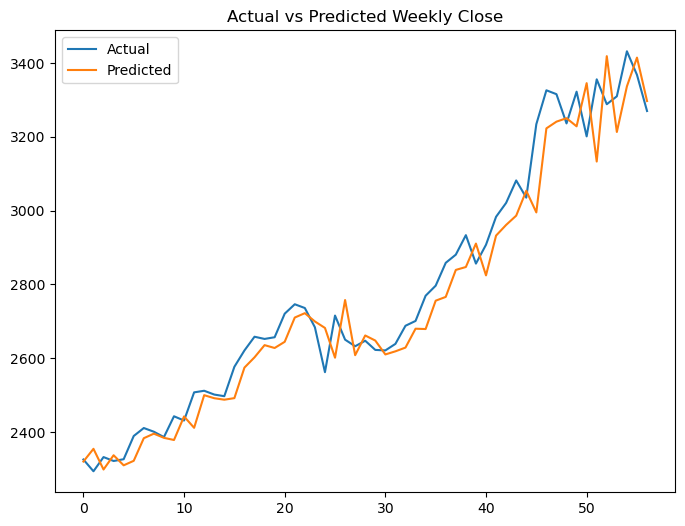

In [143]:
# Plot actual vs predicted line chart on test set
plt.figure(figsize=(8, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title("Actual vs Predicted Weekly Close")
plt.legend()
plt.show()

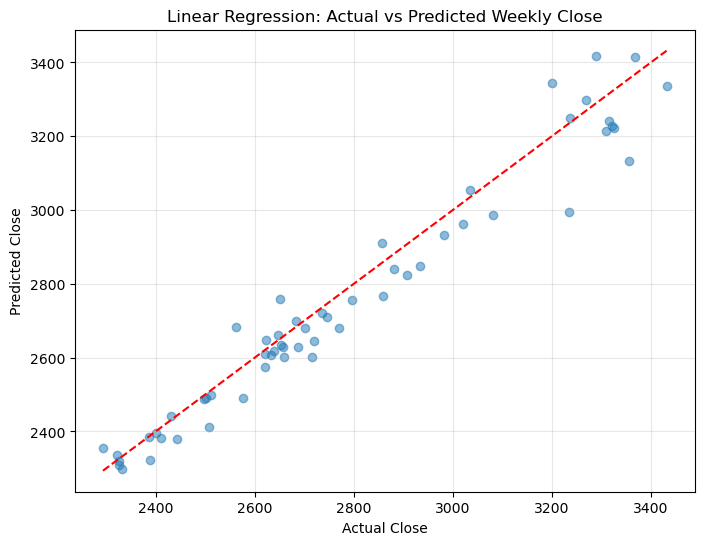

In [144]:
# Plot actual vs predicted scatter plot on test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Close')
plt.ylabel('Predicted Close')
plt.title('Linear Regression: Actual vs Predicted Weekly Close')
plt.grid(True, alpha=0.3)

In [145]:
# Compute performance metrics on test data

model_test_mae = mean_absolute_error(y_test, y_test_pred)
model_test_mse = mean_squared_error(y_test, y_test_pred)
model_test_rmse = np.sqrt(model_test_mse)
model_test_mape = mean_absolute_percentage_error(y_test, y_test_pred)*100
model_test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f"Linear Regression Performance on Test Data:")
print(f"Model - MAE:  {model_test_mae:.3f}")
print(f"        MSE:  {model_test_mse:.3f}")
print(f"        RMSE: {model_test_rmse:.3f}")
print(f"        MAPE: {model_test_mape:.3f}")
print(f"        R²:   {model_test_r2:.3f}")

Linear Regression Performance on Test Data:
Model - MAE:  58.420
        MSE:  5871.578
        RMSE: 76.626
        MAPE: 2.023
        R²:   0.946


In [146]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1 entries, 2025-06-22 to 2025-06-22
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Open                   1 non-null      float64
 1   High                   1 non-null      float64
 2   Low                    1 non-null      float64
 3   Close                  1 non-null      float64
 4   Tick_Vol               1 non-null      int64  
 5   SMA_3                  1 non-null      float64
 6   SMA_5                  1 non-null      float64
 7   Momentum_1w            1 non-null      float64
 8   Momentum_2w            1 non-null      float64
 9   Pct_Change_2w          1 non-null      float64
 10  Volatility             1 non-null      float64
 11  Volatility_3w          1 non-null      float64
 12  Close_Open_ratio       1 non-null      float64
 13  Volume_Change          1 non-null      float64
 14  Volatility_per_Tick    1 non-null      fl

In [147]:
# last row features selection
features = [
    'SMA_3', 'SMA_5',
    'Momentum_1w', 'Momentum_2w', 'Pct_Change_2w', 'Volatility',
    'Volatility_3w', 'Close_Open_ratio', 'Volume_Change',
    'Volatility_per_Tick', 'Close_lag1'
]
X_last = df2[features]

In [148]:
# Scale the last row features
X_last_scaled = scaler.transform(X_last)
# Predict the next week's high price
predicted_next = model.predict(X_last_scaled)
# Extract scalar value from the prediction
predicted_next = predicted_next[0]
print(f"Predicted XAUUSD Weekly Close for the week of <2025-06-29>: {predicted_next:.3f}")


Predicted XAUUSD Weekly Close for the week of <2025-06-29>: 3317.218


/home/hujianjin/miniconda3/envs/forecasting_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


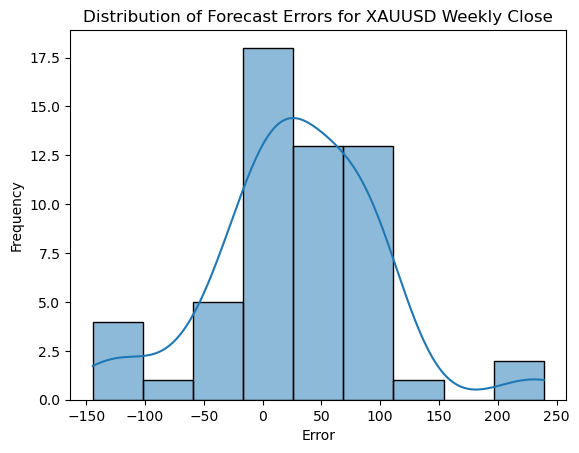

In [149]:
# Histogram + density curve of forecast errors
errors = y_test - y_test_pred  # residuals/errors
sns.histplot(errors, kde=True)
plt.title("Distribution of Forecast Errors for XAUUSD Weekly Close")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

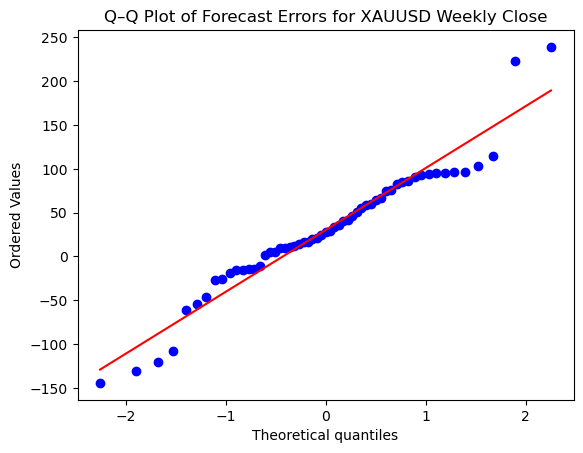

In [150]:
# Q–Q Plot of forecast errors
stats.probplot(errors, dist="norm", plot=plt)
plt.title("Q–Q Plot of Forecast Errors for XAUUSD Weekly Close")
plt.show()


In [151]:
from scipy.stats import t, norm

def probabilistic_ranges(predicted_price, rmse, mape, confidence=0.68, n=None):
    """
    Calculate RMSE-based and MAPE-based probabilistic ranges for a predicted value.
    Automatically uses t-distribution if sample size (n) is provided and n < 100.
    """
    # Ensure MAPE is in decimal form
    if mape > 1:
        mape = mape / 100.0
    
    # Choose correct distribution for critical value
    if n is not None and n < 100:
        z_or_t = t.ppf(0.5 + confidence / 2, df=n - 1)
        dist_used = "t-distribution"
    else:
        z_or_t = norm.ppf(0.5 + confidence / 2)
        dist_used = "z-distribution"
    
    # --- RMSE-based ---
    rmse_margin = z_or_t * rmse
    rmse_lower = predicted_price - rmse_margin
    rmse_upper = predicted_price + rmse_margin
    
    # --- MAPE-based ---
    sigma_pct = mape / 0.8  # Approx std dev of % errors
    mape_margin_pct = z_or_t * sigma_pct
    mape_lower = predicted_price * (1 - mape_margin_pct)
    mape_upper = predicted_price * (1 + mape_margin_pct)
    
    return {
        "confidence": confidence,
        "critical_value": z_or_t,
        "distribution_used": dist_used,
        "rmse_based": {
            "margin_abs": rmse_margin,
            "lower": rmse_lower,
            "upper": rmse_upper
        },
        "mape_based": {
            "margin_pct": mape_margin_pct * 100,  # in %
            "lower": mape_lower,
            "upper": mape_upper
        }
    }

# Next week's actual close and prediction range
actual_price = 3336.100
predicted_price = 3317.218
rmse = 76.626
mape = 2.023  # in %
n = 57  # size of test dataset

ranges = probabilistic_ranges(predicted_price, rmse, mape, confidence=0.68, n=n)

print(f"--- {ranges['confidence']*100:.0f}% Probabilistic Ranges ({ranges['distribution_used']}) ---")
print(f"RMSE-based: {ranges['rmse_based']['lower']:.2f} – {ranges['rmse_based']['upper']:.2f} "
      f"(±{ranges['rmse_based']['margin_abs']:.2f})")
print(f"MAPE-based: {ranges['mape_based']['lower']:.2f} – {ranges['mape_based']['upper']:.2f} "
      f"(±{ranges['mape_based']['margin_pct']:.2f}%)")



--- 68% Probabilistic Ranges (t-distribution) ---
RMSE-based: 3240.33 – 3394.10 (±76.88)
MAPE-based: 3233.05 – 3401.38 (±2.54%)


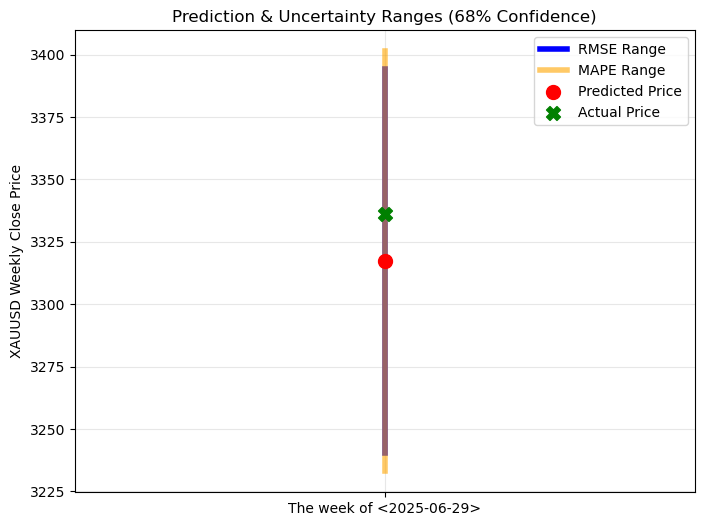

In [152]:
# Extract values from the ranges dictionary
rmse_lower = ranges['rmse_based']['lower']
rmse_upper = ranges['rmse_based']['upper']
mape_lower = ranges['mape_based']['lower']
mape_upper = ranges['mape_based']['upper']

# X-axis will just be a placeholder for the prediction point
x_pos = 0

plt.figure(figsize=(8, 6))

# --- RMSE-based range ---
plt.plot([x_pos, x_pos], [rmse_lower, rmse_upper], color='blue', linewidth=4, label='RMSE Range')

# --- MAPE-based range ---
plt.plot([x_pos, x_pos], [mape_lower, mape_upper], color='orange', linewidth=4, alpha=0.6, label='MAPE Range')

# --- Predicted price ---
plt.scatter(x_pos, predicted_price, color='red', s=100, zorder=3, label='Predicted Price')

# --- Actual price ---
plt.scatter(x_pos, actual_price, color='green', s=100, zorder=3, marker='X', label='Actual Price')

# Labels and legend
plt.xticks([x_pos], ['The week of <2025-06-29>'])
plt.ylabel('XAUUSD Weekly Close Price')
plt.title(f"Prediction & Uncertainty Ranges ({ranges['confidence']*100:.0f}% Confidence)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()
